### First sketches

#### General imports and definitions

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.1


Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Load and clean the dataset

In [3]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')

#Note as sequences are already built, with window 36
print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float64
(2429,), int32


In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
print(X_train.shape)
print(X_test.shape)

# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(2064, 36, 6)
(365, 36, 6)
{0: 5.931034482758621, 1: 1.638095238095238, 2: 0.7510917030567685, 3: 0.5308641975308642, 4: 3.2452830188679247, 5: 1.323076923076923, 6: 0.6466165413533834, 7: 2.9655172413793105, 8: 1.6862745098039216, 9: 0.2606060606060606, 10: 2.646153846153846, 11: 4.0}
(2064, 12)
(365, 12)


In [5]:
scaling = False

# TODO: fix
if scaling:
    # Preparation for data scaling
    scaler = MinMaxScaler()
    dim_train = X_train.shape[0]
    dim_test = X_test.shape[0]

    X_train_2d = np.reshape(X_train, (dim_train * 36, 6))
    X_test_2d = np.reshape(X_test, (dim_test * 36, 6))
    # Fit the scaler to the training data and apply the scaling on the training data
    X_train = scaler.fit_transform(X_train_2d)
    # Apply the scaling on validation data
    X_test = scaler.transform(X_test_2d)
    # Getting back to orginal shape
    X_train = np.reshape(X_train, (dim_train, 36, 6))
    X_test = np.reshape(X_test, (dim_test, 36, 6))

#### Metadata

In [6]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

#### Support functions

In [7]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

#### Vanilla LSTM

In [8]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(256, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(256, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(256)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='vanilla_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [9]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "vanilla_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 256)           269312    
                                                                 
 lstm_1 (LSTM)               (None, 36, 256)           525312    
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 12)                3084      
                                                                 
Total params: 1,323,020
Trainable params: 1,323,020
N

In [10]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Plot results
plot_history(history)
plot_cm(model)

Epoch 1/200
17/17 [==============================] - 15s 490ms/step - loss: 2.4913 - accuracy: 0.0349 - val_loss: 2.4850 - val_accuracy: 0.1288 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 7s 426ms/step - loss: 2.4902 - accuracy: 0.0552 - val_loss: 2.4947 - val_accuracy: 0.0247 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 7s 416ms/step - loss: 2.4887 - accuracy: 0.0446 - val_loss: 2.4687 - val_accuracy: 0.0329 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 8s 449ms/step - loss: 2.4899 - accuracy: 0.0862 - val_loss: 2.4822 - val_accuracy: 0.0137 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 8s 447ms/step - loss: 2.4871 - accuracy: 0.0547 - val_loss: 2.4805 - val_accuracy: 0.0137 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 8s 451ms/step - loss: 2.4856 - accuracy: 0.0896 - val_loss: 2.4780 - val_accuracy: 0.1589 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 8s 461ms/s

KeyboardInterrupt: 

#### Bidirectional LSTM

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='bd_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "bd_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 512)          538624    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 512)          1574912   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                          

Epoch 1/200
17/17 [==============================] - 28s 1s/step - loss: 2.0238 - accuracy: 0.2292 - val_loss: 1.7793 - val_accuracy: 0.3178 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 15s 903ms/step - loss: 1.4215 - accuracy: 0.4041 - val_loss: 1.8172 - val_accuracy: 0.3479 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 17s 1s/step - loss: 1.2531 - accuracy: 0.4234 - val_loss: 1.4393 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 17s 995ms/step - loss: 1.0131 - accuracy: 0.5121 - val_loss: 1.3681 - val_accuracy: 0.4247 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 29s 2s/step - loss: 0.8322 - accuracy: 0.5349 - val_loss: 1.3318 - val_accuracy: 0.4548 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 13s 794ms/step - loss: 0.7403 - accuracy: 0.5741 - val_loss: 1.3151 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 19s 1s/step - 

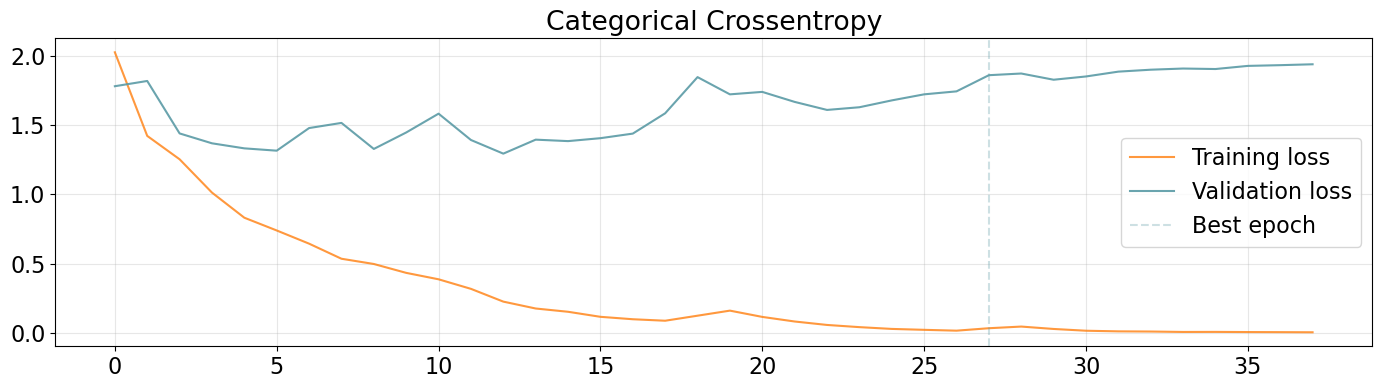

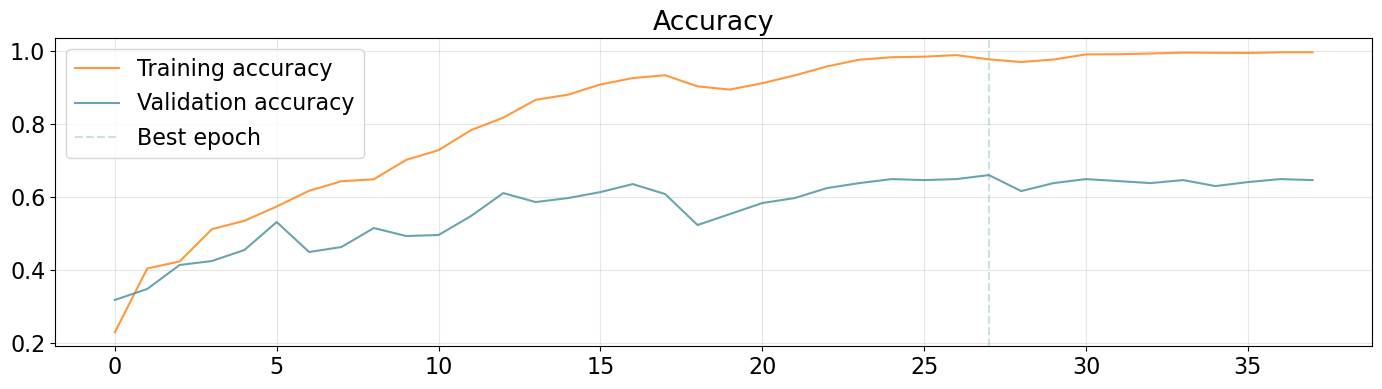

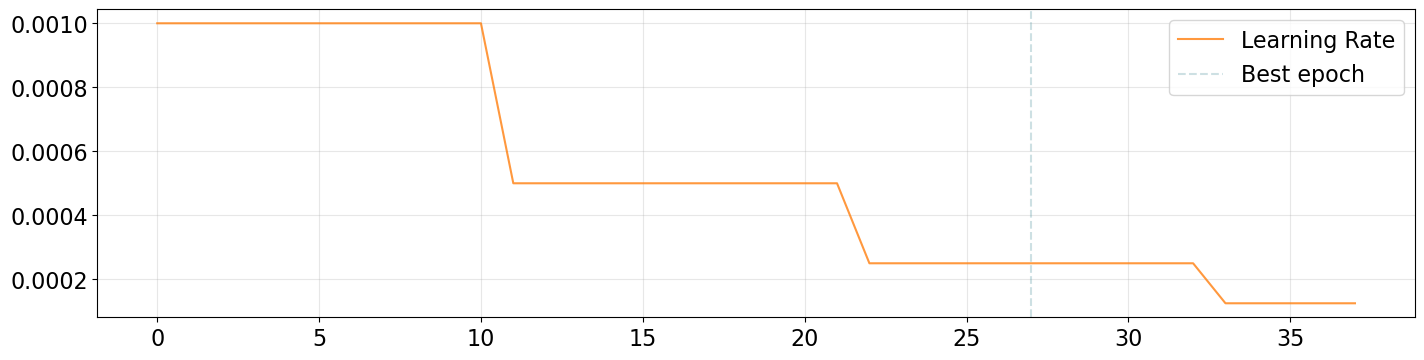

12/12 [==============================] - 4s 82ms/step
Accuracy: 0.6603
Precision: 0.6744
Recall: 0.5969
F1: 0.6079


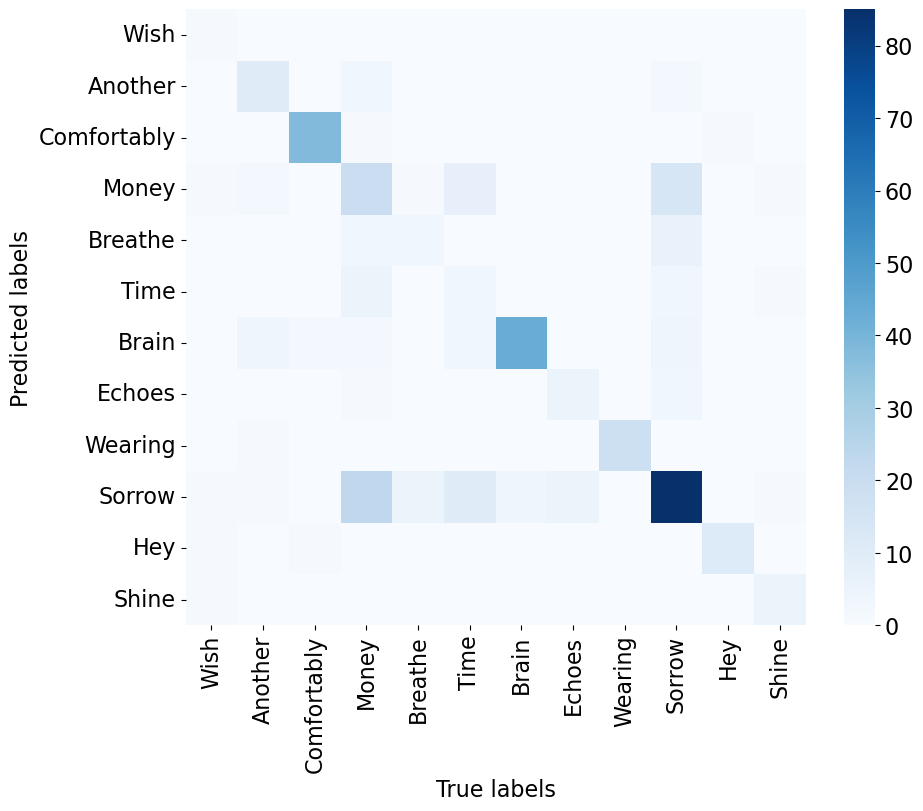

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Plot results
plot_history(history)
plot_cm(model)